# WARNING DO NOT COMMIT DIRECTLY TO MAIN GET ON YOUR OWN BRANCH FIRST 🙏🏼🙌🏼

# Setting up the GPU for use!

In [15]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 1234


## First import frame without confidental columns!

In [16]:
education_data = pd.read_csv('students_clean.csv')
education_data

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,Female,22,Mathematics,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,F,10.3,Yes,No,Master's,Medium,1,5.9
1,Male,18,Business,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,B,27.1,No,No,High School,Low,4,4.3
2,Male,24,Engineering,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,D,12.4,Yes,No,High School,Low,9,6.1
3,Female,24,Engineering,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,F,25.5,No,Yes,High School,Low,8,4.9
4,Female,23,CS,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,C,13.3,Yes,No,Master's,Medium,6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,19,CS,96.09,45.86,45.63,74.13,81.53,9.8,51.66,53.5470,F,7.8,No,No,Master's,Medium,10,4.5
4996,Male,19,Mathematics,96.30,78.67,47.42,57.89,85.96,47.8,52.33,59.0240,F,24.2,No,Yes,NaN,Medium,4,7.2
4997,Female,24,CS,89.94,50.84,65.83,84.69,82.27,7.5,97.89,74.7560,C,7.6,No,Yes,NaN,High,5,6.6
4998,Male,23,Engineering,99.09,55.44,57.45,78.78,55.96,62.9,84.74,68.6585,D,14.5,Yes,No,PhD,Medium,10,5.9


## Removing Parent Education

In [17]:
education_data.drop('Parent_Education_Level', axis=1, inplace=True) 
education_data

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,Female,22,Mathematics,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,F,10.3,Yes,No,Medium,1,5.9
1,Male,18,Business,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,B,27.1,No,No,Low,4,4.3
2,Male,24,Engineering,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,D,12.4,Yes,No,Low,9,6.1
3,Female,24,Engineering,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,F,25.5,No,Yes,Low,8,4.9
4,Female,23,CS,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,C,13.3,Yes,No,Medium,6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,19,CS,96.09,45.86,45.63,74.13,81.53,9.8,51.66,53.5470,F,7.8,No,No,Medium,10,4.5
4996,Male,19,Mathematics,96.30,78.67,47.42,57.89,85.96,47.8,52.33,59.0240,F,24.2,No,Yes,Medium,4,7.2
4997,Female,24,CS,89.94,50.84,65.83,84.69,82.27,7.5,97.89,74.7560,C,7.6,No,Yes,High,5,6.6
4998,Male,23,Engineering,99.09,55.44,57.45,78.78,55.96,62.9,84.74,68.6585,D,14.5,Yes,No,Medium,10,5.9


## Encoding Gender & Extra cericulars & Internet at home!

In [18]:
education_data['Gender'] = education_data['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)
education_data['Internet_Access_at_Home'] = education_data['Internet_Access_at_Home'].replace({'Yes': 1, 'No': 0}).astype(int)
education_data['Extracurricular_Activities'] = education_data['Extracurricular_Activities'].replace({'Yes': 1, 'No': 0}).astype(int)
education_data.head()

/tmp/ipykernel_689163/2184960641.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education_data['Gender'] = education_data['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)
/tmp/ipykernel_689163/2184960641.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education_data['Internet_Access_at_Home'] = education_data['Internet_Access_at_Home'].replace({'Yes': 1, 'No': 0}).astype(int)
/tmp/ipykernel_689163/2184960641.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,0,22,Mathematics,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,F,10.3,1,0,Medium,1,5.9
1,1,18,Business,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,B,27.1,0,0,Low,4,4.3
2,1,24,Engineering,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,D,12.4,1,0,Low,9,6.1
3,0,24,Engineering,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,F,25.5,0,1,Low,8,4.9
4,0,23,CS,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,C,13.3,1,0,Medium,6,4.5


## Encoding Family Income!

In [19]:
import pandas as pd

# Low = 1, Medium = 2, High = 3
mapper = {'low': 1, 'medium': 2, 'high': 3}

education_data['Family_Income_Level'] = (
    education_data['Family_Income_Level']
      .astype(str)                  # works even if the value is already 1/2/3 or NaN
      .str.strip().str.lower()
      .map(mapper)                  # returns NaN where no mapping found
      .fillna(education_data['Family_Income_Level'])  # keepin the original numeric/blank entries
      .astype('Int64')              #  nullable integer dtype
)

education_data

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,0,22,Mathematics,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,F,10.3,1,0,2,1,5.9
1,1,18,Business,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,B,27.1,0,0,1,4,4.3
2,1,24,Engineering,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,D,12.4,1,0,1,9,6.1
3,0,24,Engineering,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,F,25.5,0,1,1,8,4.9
4,0,23,CS,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,C,13.3,1,0,2,6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,19,CS,96.09,45.86,45.63,74.13,81.53,9.8,51.66,53.5470,F,7.8,0,0,2,10,4.5
4996,1,19,Mathematics,96.30,78.67,47.42,57.89,85.96,47.8,52.33,59.0240,F,24.2,0,1,2,4,7.2
4997,0,24,CS,89.94,50.84,65.83,84.69,82.27,7.5,97.89,74.7560,C,7.6,0,1,3,5,6.6
4998,1,23,Engineering,99.09,55.44,57.45,78.78,55.96,62.9,84.74,68.6585,D,14.5,1,0,2,10,5.9


## Encoding Department Info!

In [20]:
labels = open('departments.txt').read().splitlines()
department_mapping = {name: index for index, name in enumerate(labels)}
department_indices = education_data['Department'].map(department_mapping)
education_data.insert(3, 'department index', department_indices)
education_data

,Gender,Age,Department,department index,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,0,22,Mathematics,0,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,F,10.3,1,0,2,1,5.9
1,1,18,Business,1,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,B,27.1,0,0,1,4,4.3
2,1,24,Engineering,2,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,D,12.4,1,0,1,9,6.1
3,0,24,Engineering,2,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,F,25.5,0,1,1,8,4.9
4,0,23,CS,3,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,C,13.3,1,0,2,6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,19,CS,3,96.09,45.86,45.63,74.13,81.53,9.8,51.66,53.5470,F,7.8,0,0,2,10,4.5
4996,1,19,Mathematics,0,96.30,78.67,47.42,57.89,85.96,47.8,52.33,59.0240,F,24.2,0,1,2,4,7.2
4997,0,24,CS,3,89.94,50.84,65.83,84.69,82.27,7.5,97.89,74.7560,C,7.6,0,1,3,5,6.6
4998,1,23,Engineering,2,99.09,55.44,57.45,78.78,55.96,62.9,84.74,68.6585,D,14.5,1,0,2,10,5.9


## Encoding Grade!

In [21]:
# Low = 1, Medium = 2, High = 3
mapper = {'A': 1, 'B': 1, 'C': 1, 'D':0,'F':0}

education_data['Grade'] = (
    education_data['Grade']
      .astype(str)              # convert everything to string
      .str.strip().str.upper()  # remove spaces and standardize to uppercase
      .map(mapper)              # map letters to numbers
)

education_data.head()

,Gender,Age,Department,department index,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,0,22,Mathematics,0,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,0,10.3,1,0,2,1,5.9
1,1,18,Business,1,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,1,27.1,0,0,1,4,4.3
2,1,24,Engineering,2,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,0,12.4,1,0,1,9,6.1
3,0,24,Engineering,2,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,0,25.5,0,1,1,8,4.9
4,0,23,CS,3,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,1,13.3,1,0,2,6,4.5


In [22]:
education_data.columns
# Count occurrences of each grade
grade_counts = education_data['Grade'].value_counts().sort_index()

# Optionally, map the numbers back to letters for readability
#reverse_mapper = {v: k for k, v in mapper.items()}
#grade_counts.index = grade_counts.index.map(reverse_mapper)

print(grade_counts)


Grade
0    2039
1    2961
Name: count, dtype: int64


Website for weights formula:

https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75

In [23]:
# Website for weights formula:



dataset_size = education_data.shape[0]
grades_weight_lst = []


for grade in list(set(education_data['Grade'])):
    grades_weight_lst.append(dataset_size/grade_counts[grade])
    
grades_weight_lst[0] =  grades_weight_lst[0] * 1.2
grades_weight_lst = torch.tensor(grades_weight_lst).float().to(device)

grades_weight_lst

tensor([2.9426, 1.6886], device='cuda:0')

In [24]:
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        x = torch.tensor(row[self.feature_cols].to_numpy(dtype=np.float32), dtype=torch.float32)
        y = torch.tensor(row[self.target_col[0]], dtype=torch.long)  # long for classification
        return x, y


In [25]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(education_data, train_size=0.8)
train_df,dev_df = train_test_split(train_df, train_size=0.8)

train_df.reset_index(inplace=True,drop=True)
dev_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)


print(f'train rows: {len(train_df.index):,}')
print(f'dev rows: {len(dev_df.index):,}')
print(f'test rows: {len(test_df.index):,}')

train rows: 3,200
dev rows: 800
test rows: 1,000


In [26]:
train_df = train_df.drop(columns='Department')
train_df

,Gender,Age,department index,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,1,24,2,78.29,81.18,53.20,74.12,71.16,43.2,93.40,73.8910,1,29.4,1,1,3,3,8.2
1,0,21,2,94.35,85.81,88.13,82.42,72.98,19.0,76.91,78.5880,1,8.4,1,1,1,10,5.1
2,0,23,1,78.44,86.77,60.85,61.37,83.64,49.4,66.74,68.2895,0,17.8,0,0,2,3,5.3
3,1,21,1,50.40,57.41,92.83,94.56,83.55,34.5,54.77,72.5140,1,20.6,1,1,3,6,6.8
4,0,23,3,56.93,70.74,51.35,65.14,93.35,94.9,83.88,72.4635,1,23.2,0,0,2,8,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,1,22,2,51.59,70.92,64.44,89.38,69.36,74.3,83.86,75.9640,1,25.3,1,0,3,9,5.9
3196,1,19,3,53.47,87.09,54.19,61.44,55.01,2.4,61.52,59.9040,0,18.8,0,1,3,7,7.0
3197,1,21,3,73.67,51.74,54.54,90.71,94.01,32.3,97.02,75.1245,1,12.2,0,0,1,1,5.2
3198,0,23,0,63.82,80.90,90.50,86.40,95.19,39.9,69.49,80.0810,1,8.6,0,0,1,7,8.9


In [27]:
from imblearn.over_sampling import SMOTE


#for col in train_df.columns.to_list():
   # train_df[col] = train_df[col].apply(lambda x: int(x))


#x_train = train_df.drop(columns='Grade')
#y_train = train_df[['Grade']]

#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(x_train,y_train)
#new_train = X_res.join(y_res)


#grade_counts = new_train['Grade'].value_counts().sort_index()
#grade_counts

#train_df = new_train.copy()

In [28]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, vocab_sz,embedding_dim):
        super().__init__()
        # This will be the embedding layer right now just for the department col.
        self.embed = nn.Embedding(num_embeddings=(vocab_sz+1),embedding_dim=embedding_dim)
        
        # This is just the base linear fnn from class.
        self.layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
        
        
    def forward(self, x):
        # First compute the embedding for the department col.
        #print(x[:,0].max(),x[:,0].min(),64)
        #embed_out = self.embed(x[:,0].long())
        #print(x[:,0].shape)

        # Now concat the output embedding and our embedding.
        #x_embed_and_inputs = torch.cat([embed_out,x[:,1:]],dim=1)

        # Now pass the embedding and all the other inputs to the linear layers that will produce the
        # output.
        return self.layers(x)

In [29]:
vocab_sz = education_data['department index'].max()

In [30]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

train_df[['Total_Score', 'Final_Score', 'Projects_Score', 'Assignments_Avg',
       'Midterm_Score', 'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities','Grade']]
dev_df [['Total_Score', 'Final_Score', 'Projects_Score', 'Assignments_Avg',
       'Midterm_Score', 'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities','Grade']]

# hyperparameters
feature_cols= ['Total_Score', 'Final_Score', 'Projects_Score', 'Assignments_Avg',
       'Midterm_Score', 'Quizzes_Avg', 'Participation_Score',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Extracurricular_Activities']

target_col = ['Grade']
lr = 1e-3
weight_decay = 1e-5

batch_size = 50
shuffle = True
n_epochs = 12
input_dim = len(feature_cols)
hidden_dim = 100
output_dim = 2
dropout = 0.3
embedding_dim = 64

# initialize the model, loss function, optimizer, and data-loader
model = Model(input_dim, hidden_dim, output_dim, dropout, vocab_sz, embedding_dim).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay)
train_ds = MyDataset(
    train_df,feature_cols,target_col)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=shuffle)
dev_ds = MyDataset(
   dev_df,feature_cols,target_col)
dev_dl = DataLoader(
    dev_ds,
    batch_size=batch_size,
    shuffle=shuffle)

# lists used to store plotting data
train_loss, train_acc = [], []
dev_loss, dev_acc = [], []

In [31]:
# train the model
for epoch in range(n_epochs):
    losses, acc = [], []
    # set model to training mode
    model.train()
    for X, y_true in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'):
        # clear gradients
        model.zero_grad()
        # send batch to right device
        X = X.to(device)
        y_true = y_true.to(device)
        # predict label scores
        y_pred = model(X)
        # compute loss
        loss = loss_func(y_pred, y_true)
        # compute accuracy
        gold = y_true.detach().cpu().numpy()
        pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1)
        # accumulate for plotting
        losses.append(loss.detach().cpu().item())
        acc.append(accuracy_score(gold, pred))
        # backpropagate
        loss.backward()
        # optimize model parameters
        optimizer.step()
    # save epoch stats
    train_loss.append(np.mean(losses))
    train_acc.append(np.mean(acc))
    
    # set model to evaluation mode
    model.eval()
    # disable gradient calculation
    with torch.no_grad():
        losses, acc = [], []
        for X, y_true in tqdm(dev_dl, desc=f'epoch {epoch+1} (dev)'):
            # send batch to right device
            X = X.to(device)
            y_true = y_true.to(device)
            # predict label scores
            y_pred = model(X)
            # compute loss
            loss = loss_func(y_pred, y_true)
            # compute accuracy
            gold = y_true.cpu().numpy()
            pred = np.argmax(y_pred.cpu().numpy(), axis=1)
            # accumulate for plotting
            losses.append(loss.cpu().item())
            acc.append(accuracy_score(gold, pred))
        # save epoch stats
        dev_loss.append(np.mean(losses))
        dev_acc.append(np.mean(acc))

epoch 1 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 1 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 2 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 2 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 3 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 3 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 4 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 4 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 5 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 5 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 6 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 6 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 7 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 7 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 8 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 8 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 9 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 9 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 10 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 10 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 11 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 11 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

epoch 12 (train):   0%|          | 0/64 [00:00<?, ?it/s]

epoch 12 (dev):   0%|          | 0/16 [00:00<?, ?it/s]

In [32]:
dev_df[dev_df['Grade']==0]

,Gender,Age,Department,department index,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,0,22,Business,1,88.62,57.10,82.04,58.05,67.94,50.6,69.42,67.9325,0,13.2,0,1,1,4,7.3
2,0,19,CS,3,96.85,65.37,47.49,65.54,84.30,19.9,89.04,67.6460,0,17.5,1,1,2,5,4.2
3,0,18,Business,1,83.65,74.86,53.80,82.24,50.62,61.6,56.19,62.0140,0,19.9,1,1,2,1,7.9
5,1,24,Engineering,2,52.21,66.91,48.97,77.94,63.19,99.1,64.20,64.5040,0,10.2,0,0,2,2,4.7
8,1,19,Mathematics,0,50.02,68.87,52.19,52.10,97.51,79.2,71.57,66.3750,0,10.5,0,1,3,7,8.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,1,22,Mathematics,0,51.97,45.24,46.15,86.12,77.01,1.2,63.40,58.0225,0,26.9,1,0,1,10,8.0
793,1,23,Engineering,2,52.45,69.77,62.71,59.42,50.30,39.9,80.76,66.3090,0,9.9,0,1,2,5,7.6
794,1,22,Engineering,2,79.45,69.33,58.33,70.82,90.18,98.7,61.89,68.1250,0,20.8,0,1,1,2,7.8
795,1,24,CS,3,72.48,43.83,84.38,51.03,76.21,51.0,73.84,67.6470,0,9.9,0,1,1,4,6.0


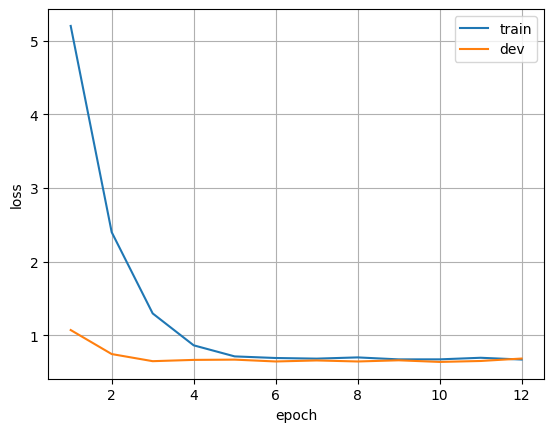

In [33]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs) + 1

plt.plot(x, train_loss)
plt.plot(x, dev_loss)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

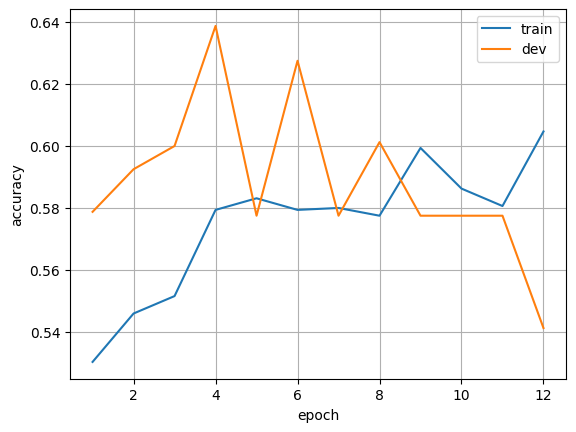

In [34]:

plt.plot(x, train_acc)
plt.plot(x, dev_acc)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)

In [35]:
from sklearn.metrics import classification_report
dev_ds = MyDataset(
   dev_df,feature_cols,target_col)
dev_dl = DataLoader(
    dev_ds,
    batch_size=batch_size,
    shuffle=shuffle)
# set model to evaluation mode
model.eval()

y_pred = []

# disable gradient calculation
with torch.no_grad():
    for X, _ in tqdm(dev_dl):
        # send batch to right device
            X = X.to(device)
            # predict label scores
            y = model(X)
            predictedLabel= torch.argmax(y, dim=1)
            # convert tensor to numpy array
            y_pred.append(predictedLabel.cpu().numpy())
    
# print results
print("Unique y_true:", sorted(y_true.unique()))
print("Unique y_pred:", sorted(np.unique(y_pred)))

y_true = dev_df['Grade']
y_pred = np.concatenate(y_pred)
print(classification_report(y_true, y_pred, target_names=['0','1']))

  0%|          | 0/16 [00:00<?, ?it/s]

Unique y_true: [tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
Unique y_pred: [0, 1]
              precision    recall  f1-score   support

           0       0.43      0.76      0.55       338
           1       0.60      0.26      0.36       462

    accuracy                           0.47       800
   macro avg       0.51      0.51      0.46       800
weighted avg       0.53      0.47      0.44       800



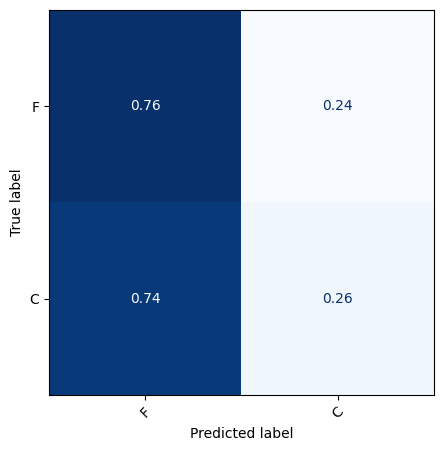

In [36]:

# make sure y_true and y_pred exist
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = dev_df['Grade']

# check if y_pred is a list or a numpy array
y_pred_array = y_pred  # already a numpy array

# define classes and display names
classes = [0,1]
reverse_mapper = {0:'A',1:'B',1:'C',0:'D',0:'F'}
display_names = [reverse_mapper[c] for c in classes]

# compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred_array, labels=classes, normalize='true')

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax, xticks_rotation=45)
plt.show()
 
